### Regresión polinomial con perceptrón

#### Definir utilidades para el código a continuación

In [1]:
def show_loss_per_epoch(epoch, epochs, step, loss):
    if epoch%step == 0 or epoch == 0 or epoch == epochs:
        computed_loss = round(loss.item(), 4)
        print(f"{Fore.LIGHTRED_EX}Epoch: {Fore.RESET}{epoch}\t{Fore.LIGHTMAGENTA_EX}loss: {Fore.RESET}{computed_loss}")

In [2]:
def check_torch():
    print(f"{Fore.LIGHTRED_EX}Pytorch version: {Fore.LIGHTMAGENTA_EX}{torch.__version__}{Fore.RESET}")
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print(f"{Fore.LIGHTMAGENTA_EX}The current {Fore.LIGHTRED_EX}Pytorch{Fore.LIGHTMAGENTA_EX} installation was built with MPS activated{Fore.RESET}")

In [3]:
from sklearn.metrics import r2_score

def compute_r2(y_true, y_pred):
    rr = r2_score(tof, y_pred)
    r2 = round(rr, 6)
    print(f"{Fore.LIGHTRED_EX}R²: {Fore.RESET}{r2}")

#### Importar librerías

In [4]:
import torch
import numpy as np
from torch import nn
from colorama import Fore
from matplotlib import pyplot as plt

check_torch()

Pytorch version: 1.13.0
The current Pytorch installation was built with MPS activated


#### Definir el dispositivo en donde el modelo correrá

In [5]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

#### Definir los datos

In [6]:
tof  = np.array([15, 16.1, 16.4, 17.8, 18.7, 20.1, 21, 21.6, 23.9, 25, 25.7, 26.4, 27.9, 28.5, 30.7, 33.4, 36.5, 37.3,], float)
temp = np.array([11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 27, 31, 34, 35], float)
# intervalo en el eje x: 18 valores entre 0 y 1
t = np.arange(0, 1, 1/18, dtype=float)
# definir entradas para el regresor polinomial de grado n
s = np.array([[i**8, i**7, i**6, i**5, i**4, i**3, i**2, i] for i in t], float)
# definir el grado del regresor según s
degree = s[0].shape[0]

In [7]:
X = torch.from_numpy(s).float().to(device)
y = torch.from_numpy(tof).float().unsqueeze(dim=1).to(device)

#### Definir el modelo de regresión polinomial

In [8]:
class PolyRegressor(nn.Module):
    def __init__(self, degree):
        super(PolyRegressor, self).__init__()
        self.fc1 = nn.Linear(degree, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc1(x)

In [9]:
def train(epochs, step, X, y, model, loss_fn, optimizer):
    for epoch in range(epochs):
        optimizer.zero_grad()     # borrar gradientes para recalcular
        y_pred = model(X)         # paso hacia adelante
        loss = loss_fn(y_pred, y) # calcular función de pérdida
        loss.backward()           # retropropagación
        optimizer.step()          # actualizar los pesos
        
        show_loss_per_epoch(epoch, epochs, step, loss)

#### A) Entrenar el modelo y almacenar sus parámetros

In [10]:
# construir modelo y cargarlo al dispositivo correspondiente
model = PolyRegressor(degree)
model.to(device)
# definir función de pérdida y optimizador
loss_fn   = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
# modelo en modo de entrenamiento
model.train()
# definir el número de épocas
epochs, step = 100000, 10000
# entrenar el modelo
train(epochs, step, X, y, model, loss_fn, optimizer)

Epoch: 0	loss: 640.8918
Epoch: 10000	loss: 0.367
Epoch: 20000	loss: 0.326
Epoch: 30000	loss: 0.305
Epoch: 40000	loss: 0.2942
Epoch: 50000	loss: 0.2885
Epoch: 60000	loss: 0.2855
Epoch: 70000	loss: 0.2839
Epoch: 80000	loss: 0.283
Epoch: 90000	loss: 0.2824


In [13]:
# reguardar modelo en un diccionario
torch.save(model.state_dict(), f"models/poly_{degree}")

#### B) Generar modelo a partir de parámetros ya generados

In [ ]:
# obtener parámetros del modelo previamente guardado
model_dict = torch.load(f"models/poly_{degree}")
# construir modelo, actualizar parámetros y cargarlo al dispositivo correspondiente
model = PolyRegressor(degree)
model.load_state_dict(model_dict)
_ = model.to(device)

#### Obtener una predicción

In [14]:
# modelo en modo de evaluación
model.eval()
# obtener predicción y transformarla a un array en la cpu
y_pred = model(X).cpu().data.numpy()
y_pred

array([[14.898397],
       [15.871556],
       [16.863115],
       [17.872198],
       [18.898087],
       [19.940458],
       [20.999779],
       [22.077852],
       [23.178612],
       [24.309227],
       [25.481564],
       [26.714096],
       [28.034376],
       [29.482115],
       [31.113014],
       [33.00345 ],
       [35.25611 ],
       [38.00676 ]], dtype=float32)

#### Mostrar los datos generados

R²: 0.993683


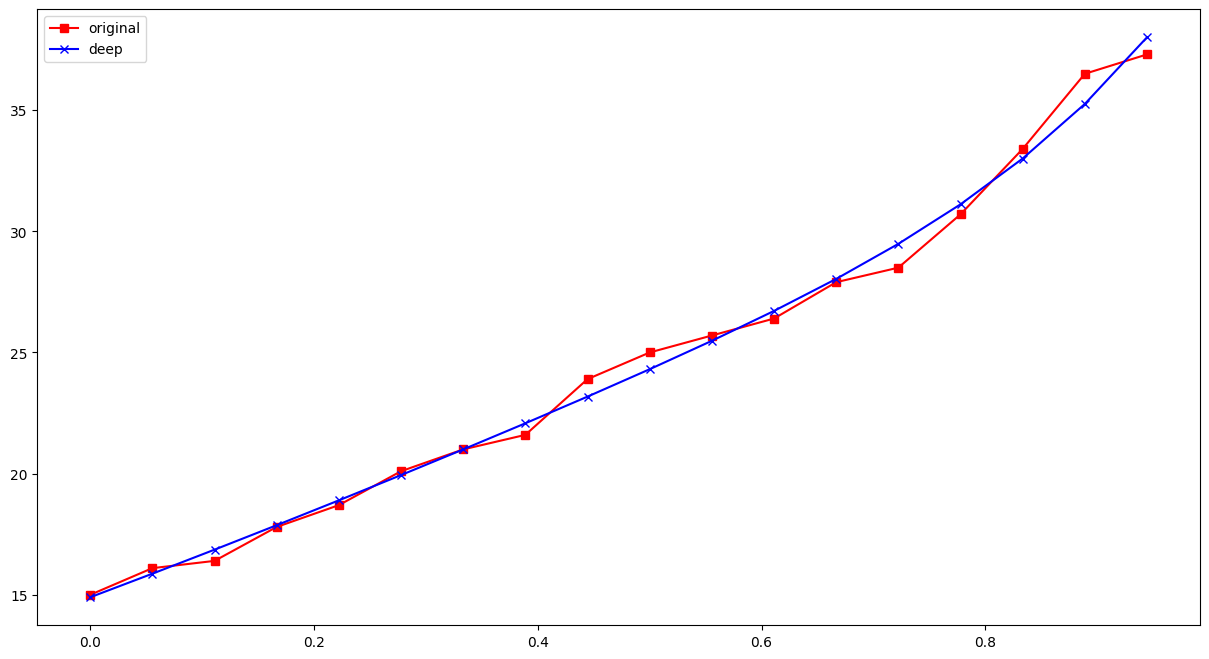

In [15]:
compute_r2(tof, y_pred)

fig = plt.figure(figsize=(15, 8))
plt.plot(t, tof, "s-r")
plt.plot(t, y_pred, "x-b")
plt.legend(["original", "deep"])
plt.show()

### Regresión polinomial con un _skit-learn_

#### Importar librerías

In [16]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

#### Generar predicción

In [17]:
def get_poly_curve(deg, x, y):
    lr = LinearRegression()
    pf = PolynomialFeatures(degree=deg)
    X  = pf.fit_transform(x.reshape(-1, 1))
    lr.fit(X, y) 
    y_pred = lr.predict(X)
    mse = mean_squared_error(y_true=tof, y_pred=y_pred)
    print(f"loss: {mse}")
    return y_pred

In [18]:
y2_pred = get_poly_curve(degree, t, tof)
y2_pred

loss: 0.06361267405511666


array([15.04210526, 15.89717593, 16.7172742 , 17.6724862 , 18.72517162,
       19.83629021, 21.00645982, 22.2418172 , 23.51040517, 24.7304617 ,
       25.80763898, 26.71383228, 27.575951  , 28.71861623, 30.58042132,
       33.39904429, 36.53615291, 37.28869565])

#### Mostrar los datos generados

R²: 0.998575


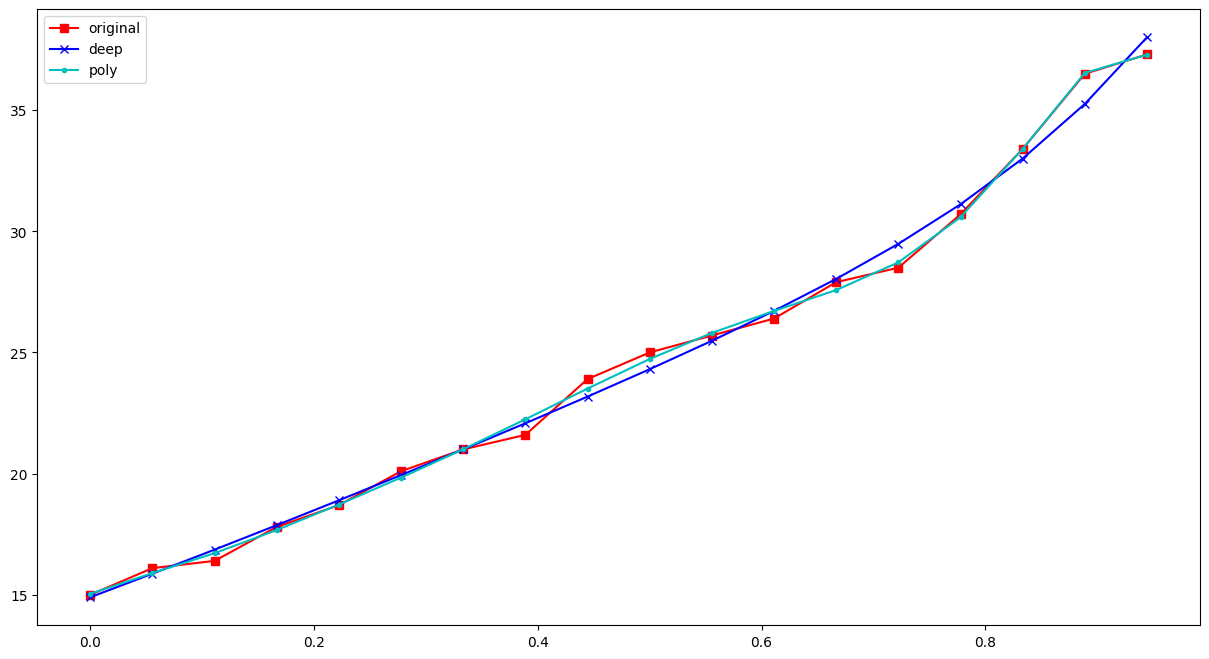

In [20]:
compute_r2(tof, y2_pred)

fig = plt.figure(figsize=(15, 8))
plt.plot(t, tof, "s-r")
plt.plot(t, y_pred, "x-b")
plt.plot(t, y2_pred, ".-c")
plt.legend(["original", "deep", "poly"])
plt.show()